In [85]:
# Imports
import networkx as nx
import pandas as pd
import numpy as np
import random
import wikipediaapi
import wikipedia
import time
import matplotlib.pyplot as plt
from scipy import spatial
from gensim.models import Word2Vec
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import spacy
import en_core_web_md # python -m spacy download en_core_web_md

wiki_wiki = wikipediaapi.Wikipedia('en')

In [21]:
# Loading data
edge_list = pd.read_csv("small_data.tsv", sep = "\t")
edge_list.head()

,source,target,depth
0,space research,advances in space research,1
1,space research,benefits of space exploration,1
2,space research,committee on space research,1
3,space research,deep space exploration,1
4,space research,lists of space programs,1


In [22]:
# Building graph
graph = nx.from_pandas_edgelist(edge_list, "source", "target", edge_attr=True)
print("Number of nodes: ", len(graph))

Number of nodes:  2096


# Node to vector representations

Algorithms:
- Deepwalk
- Node2Vec

Nodes appearing in the same context will have similar embeddings. The context is defined as sequences of nodes built by random walks.

Why not just recommend neighboring nodes instead of bothering with embeddings ? The connectedness of the nodes in a graph does not necessarily mean that they are semantically similar. Besides embeddings allow us to do linear algebra on the representations. This is especially useful for queries with multiple keywords.

In [23]:
class Deepwalk():
    """DeepWalk algorithm"""
    
    def __init__(self, graph, walk_length=10, num_walks=5):
        """Inits a Deepwalk instance.
        
        Args:
            graph: graph to embed
            walk_length: number of steps per walk
            num_walks: number of walks per starting node
        """
        
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        
        self.walks = []

        for node in graph.nodes():
            for i in range(self.num_walks):
                self.walks.append(self.build_walk(node))
        
    def build_walk(self, node, repeat_nodes=True):
    
        walk = [node]
    
        for i in range(self.walk_length-1):
            neighbors = list(self.graph.neighbors(node))
            if not repeat_nodes:
                neighbors = list(set(neighbors)-set(walk))
            if len(neighbors) == 0:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
            node = next_node

        return walk
    
    def fit(self, window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20):
        """Train Word2Vec model with skip-gram and negative sampling based on pre-computed walks"""
        return Word2Vec(self.walks, size=size, window=window, 
                        min_count=min_count, sg=sg, hs=hs, negative=negative, iter=iter)

In [24]:
deepwalk = Deepwalk(graph, walk_length=10, num_walks=5)
deepwalk_model = deepwalk.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [25]:
node2vec = Node2Vec(graph, walk_length=10, num_walks=5, quiet=True)
node2vec_model = node2vec.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [154]:
deepwalk_model.wv.similar_by_word('space tourism')

[('space flight participant', 0.7823789715766907),
 ('space tourism society', 0.660976767539978),
 ('reduced-gravity aircraft', 0.6414527297019958),
 ('seti', 0.6388373374938965),
 ('micro-g environment', 0.6359100341796875),
 ('astronaut training', 0.634943962097168),
 ('rocketship tours', 0.6173993945121765),
 ('space adventures', 0.6058911085128784),
 ('potential cultural impact of extraterrestrial contact', 0.5728671550750732),
 ('nuclear powers', 0.5621455311775208)]

In [155]:
node2vec_model.wv.similar_by_word('space tourism')

[('space flight participant', 0.7747988700866699),
 ('space tourism society', 0.7119519710540771),
 ('astronaut training', 0.6671200394630432),
 ('reduced-gravity aircraft', 0.6599216461181641),
 ('nuclear powers', 0.6450135707855225),
 ('rocketship tours', 0.6331580281257629),
 ('micro-g environment', 0.6157208681106567),
 ('seti', 0.587518036365509),
 ('spinal disc herniation', 0.5830220580101013),
 ('renal stone formation in space', 0.5714685320854187)]

In [28]:
nodes_to_plot = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
                 'moon landing','space food', 'food systems on space exploration missions', 
                 'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
                 'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
                 'space adaptation syndrome', 'micro-g environment']

In [29]:
def plot_projection(model, nodes, dim=2, projection_method=PCA):
    """Plot the projection of embeddings after applying a dimensionality reduction method."""
    node_vectors = model.wv[nodes]
    projection = projection_method(n_components=dim)
    projections = projection.fit_transform(node_vectors)
    
    plt.figure(figsize=(10,7))
    plt.scatter(projections[:,0], projections[:,1])
    for i, node in enumerate(nodes):
        plt.annotate(node, xy=(projections[i,0], projections[i,1]))
    plt.title("{} over first {} components".format(type(projection).__name__, dim))
    plt.show()

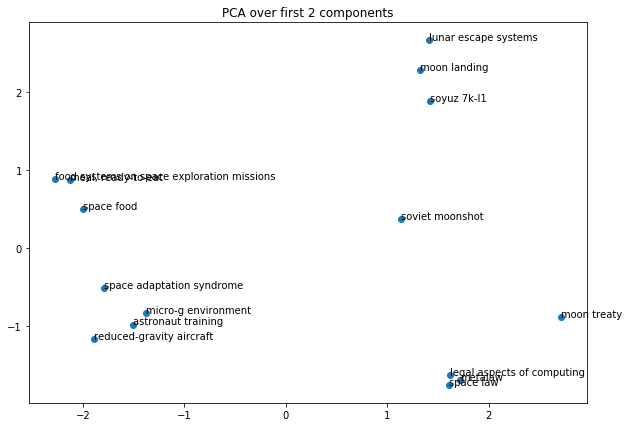

In [30]:
plot_projection(deepwalk_model, nodes_to_plot)

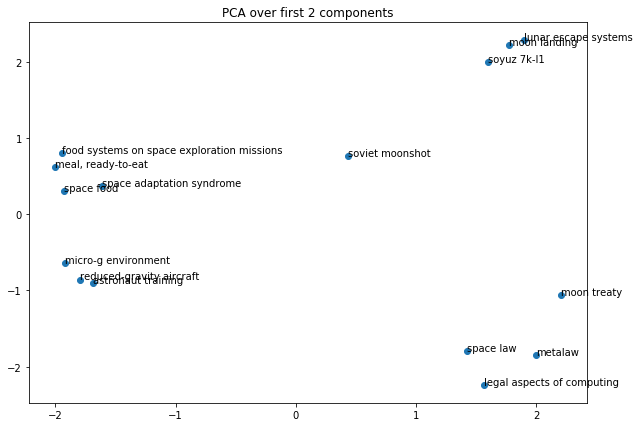

In [34]:
plot_projection(node2vec_model, nodes_to_plot)

In [95]:
def get_url(node):
    return "https://en.wikipedia.org/wiki/" + node.replace(" ", "_")

def get_url_robust(node):
    "Robust to spelling and lower case/upper case errors"
    return wikipedia.page(node).url

urls = [get_url(node) for node in graph.nodes()]

# Combining text representations and graph geometry

- Obtain representations of summaries as word2vec embeddings
- Perform some graph signal processing (for instance denoising) on the representations just as in HW2 Part 2-3

## Scalability limitations

- We would need a lot of computational resources for parsing the text and learning word embeddings from all these summaries. However one can use pre-trained embeddings to fix this issue.
- Applying ideal filters require an explicit decomposition of the graph laplacian which is not scalable. However one can resort to an ARMA filter.

In [36]:
nlp = en_core_web_md.load()

In [37]:
def get_summary(node, num_chars=1000):
        return wiki_wiki.page(node).summary[:num_chars]
    
def get_summary_robust(node, num_chars=1000):
    "Robust to spelling and lower case/upper case errors"
        try:
            return wikipedia.summary(node, chars=num_chars)[:num_chars] # summary may not return exactly num_chars
        except:
            ''

In [79]:
# Scrapping summary for each article
# ~25 sc per 100 articles. Not very efficient since we make requests sequentially and not in batch
#t = time.time()
#summaries = [get_summary(node, num_chars=10) for node in graph.nodes()]
#print("Scrapped summaries in {0:.0f} seconds".format(time.time()-t))

In [132]:
mean_embeddings = [nlp(summary).vector for summary in summaries]

In [140]:
def compute_similarities(summary, corpus, top_n=10):
    similarities = [(1 - spatial.distance.cosine(summary, s)) for s in corpus]
    top_n_indexes = np.argsort(np.asarray(similarities))[-top_n:][::-1]
    top_n_similarities = [similarities[i] for i in top_n_indexes]
    return list(zip(top_n_indexes, top_n_similarities))

In [144]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    # We initialized y arbitrarily (to the recommended value of x) 
    # as it is guaranteed to converge (as long as alpha * lambda_max < 1).
    y = x
    for _ in range(max_iter):
        y = - alpha * laplacian @ y + x
    return y

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    degree = np.sum(adjacency, axis=1)
    degree_matrix = np.diag(degree)
    laplacian = degree_matrix - adjacency
    
    if normalize:
        degree_sqrt = np.power(degree, -1/2)
        degree_sqrt_matrix = np.diag(degree_sqrt)
        laplacian = degree_sqrt_matrix @ laplacian @ degree_sqrt_matrix
        
    return laplacian

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """    
    # As we know that the Laplacian is real symmetric matrix, we can use eigh from np.linalg.
    return np.linalg.eigh(laplacian)

def GFT(signal: np.ndarray):
    return U.T @ signal
def iGFT(fourier_coefficients: np.ndarray):
    return U @ fourier_coefficients

def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    return iGFT(GFT(x) * spectral_response)

In [156]:
embeddings = np.array(mean_embeddings)
adjacency = np.asarray(nx.to_numpy_matrix(graph))
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
alpha = 0.99 / np.max(lam)
ideal_tk =  [1 / (1 + alpha * lamb) for lamb in lam]
embeddings_tk = ideal_graph_filter(embeddings, ideal_tk)
embeddings_arma = arma_tikhonov(embeddings, laplacian, alpha)

ValueError: shapes (2096,2096) and (100,300) not aligned: 2096 (dim 1) != 100 (dim 0)